# Policy Gradient

In this notebook, we will implement REINFORCE algorithm to play Catpole.

## Step 1: Import the libraries

In [1]:
import time
import random
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical

## Step 2: Create our environment

In [3]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make('CartPole-v1')
env.seed(1)

c:\users\deepanshu\.conda\envs\ai\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[1]

## Step 3: Viewing our Enviroment
Execute the code cell below to play Cartpole with a random policy.

The size of state is:  (4,)
No. of Actions:  2


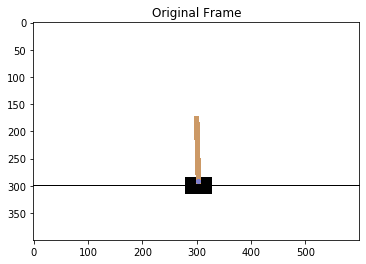

In [4]:
print("The size of state is: ", env.observation_space.shape)
print("No. of Actions: ", env.action_space.n)
env.reset()
plt.figure()
plt.imshow(env.render(mode='rgb_array'))
env.close()
plt.title('Original Frame')
plt.show()

In [5]:
def random_play():
    env.reset()
    while True:
        env.render(mode='rgb_array')
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        if done:
            env.close()
            break
random_play()

## Step 4: Creating Deep Learning Model

In [6]:
class Policy(nn.Module):
    def __init__(self, state_size = 4, action_size=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, 16)
        self.fc2 = nn.Linear(16, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

## Step 6: Creating out agent

In [7]:
GAMMA = 1.0            # discount factor
LR = 1e-2              # learning rate 

class Agent():
    def __init__(self, state_size, action_size):
        self.action_size = action_size
        self.state_size = state_size
        
        # Q-Network
        self.policy_net = Policy(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LR)
        
        self.saved_log_probs = []
        self.rewards = []
        
    
    def step(self, reward, log_probs):
        # Save rewards and log_probs
        self.rewards.append(reward)
        self.saved_log_probs.append(log_probs)
        
                
    def act(self, state):
        """Returns actions for given state as per current policy."""
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.policy_net(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)
        
    def reset(self):
        self.saved_log_probs = []
        self.rewards = []
        
    def learn(self, gamma):
        discounts = [gamma**i for i in range(len(self.rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, self.rewards)])
        
        policy_loss = []
        for log_prob in self.saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()
        
        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()

## Step 7: Watching untrained agent play

In [8]:
agent = Agent(state_size=4, action_size= env.action_space.n)

# watch an untrained agent
state = env.reset()
agent.reset()
for j in range(200):
    action, _ = agent.act(state)
    env.render()
    next_state, reward, done, _ = env.step(action)
    state = next_state
    time.sleep(0.05)
    if done:
        break 
        
env.close()

## Step 8: Loading Agent

In [9]:
start_epoch = 0
scores = []
scores_window = deque(maxlen=100)

# To Load checkpoint uncomment code
# checkpoint = torch.load('cartpole_solved.pth')
# agent.policy_net.load_state_dict(checkpoint['state_dict'])
# agent.target_net.load_state_dict(checkpoint['state_dict'])
# agent.optimizer.load_state_dict(checkpoint['optimizer'])
# start_epoch = checkpoint['epoch']
# scores = checkpoint['scores']

# index = 1
# for i in reversed(scores):
#     scores_window.append(i)
#     if index == 100:
#         break
#     index += 1

## Step 9: Train the Agent with DQN

In [10]:
def train(n_episodes=2000):
    for i_episode in range(start_epoch+1, n_episodes+1):
        state = env.reset()
        agent.reset()
        step = 0
        while True:
            action, log_probs = agent.act(state.copy())
            state, reward, done, _ = env.step(action)
            step += 1
            reward = -100 if done and step < 450 else reward  
            agent.step(reward, log_probs)
            if done:
                break
        agent.learn(GAMMA)
        scores_window.append(step)       # save most recent score
        scores.append(step)              # save most recent score
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=450:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            state = {'epoch': i_episode,'state_dict': agent.policy_net.state_dict(),'optimizer': agent.optimizer.state_dict(),
                     'scores': scores }
            torch.save(state, "cartpole_solved.pth")
            break
    
    return scores

Episode 100	Average Score: 23.70
Episode 200	Average Score: 25.49
Episode 300	Average Score: 30.43
Episode 400	Average Score: 51.99
Episode 500	Average Score: 179.75
Episode 600	Average Score: 178.88
Episode 700	Average Score: 260.52
Episode 800	Average Score: 239.01
Episode 900	Average Score: 333.37
Episode 1000	Average Score: 426.80
Episode 1100	Average Score: 282.35
Episode 1194	Average Score: 451.46Environment solved in 1094 episodes!	Average Score: 451.46


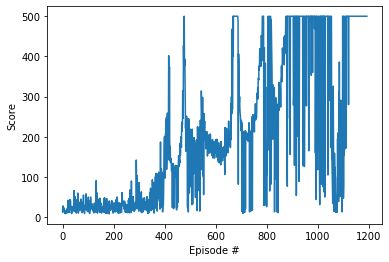

In [11]:
scores = train(2000)
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [14]:
# watch an trained agent
state = env.reset()
agent.reset()
score = 0
while True:
    action, _ = agent.act(state)
    env.render()
    next_state, reward, done, _ = env.step(action)
    score += reward
    state = next_state
    if done:
        print("Your score is: ", score)
        break 
        
env.close()

Your score is:  500.0
